In [2]:
import geopandas as gpd
import pandas as pd
from os import listdir
import numpy as np
import matplotlib.pyplot as plt
import folium
from folium import IFrame
import branca
from collections import Counter
import branca.colormap as cmp
from ast import literal_eval

import string
import uuid
import json
from scipy import stats

import itertools


from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim import models, corpora
from gensim.models.coherencemodel import CoherenceModel

from tqdm import tqdm

import matplotlib.cm as cm

from wordcloud import WordCloud

## load data

In [3]:
def try_literal_eval(s):
    """ load python object as they are intended to be """
    try:
        return literal_eval(s)
    except ValueError:
        return s

In [4]:
%%time

_df = pd.read_csv("./preprocessed_data/nlp_geo_tweets_stopwords_cleaned.csv")
for col in ["hashtags", "tokens", "tokens_cleand", "w_pos_lemma"]:
    _df[col] = _df[col].apply(literal_eval)

_df.shape

Wall time: 57.2 s


In [5]:
LOCATIONS_ID = list(set(_df.dep_code.values))

geo_departements = "./geodata/departements.geojson"
gdf_departements = gpd.read_file(geo_departements)

_id2name = pd.Series(gdf_departements.nom.values,index=gdf_departements.code).to_dict()

In [6]:
# select only regions with more tweets than average ---> can be changed
dep_count = _df.groupby("dep_code").count()[["created_at"]]
dep_count.rename(columns={"created_at":"tweet_count"}, inplace=True)
dep_count.sort_values(by="tweet_count", ascending=False)
dep_count_filtered = dep_count[dep_count.tweet_count > dep_count.tweet_count.mean()] # can be changed
selected_dep = dep_count_filtered.index.values 
df = _df[[dep in selected_dep for dep in _df.dep_code]].copy()
df["hashtags"] = [[ht.lower() for ht in hashtags] for hashtags in df.hashtags]
df.shape

(233596, 26)

In [7]:
dep_count_geo = pd.merge(df
                         , gdf_departements
                         , how='inner'
                         , right_on="code"
                         , left_on="dep_code"
                         , validate = "many_to_one"
                        ).reset_index(drop=True)
dep_count_geo["code"].astype(str)
dep_count_geo.shape

(233596, 29)

In [8]:
df_hashtags_filtered = df[[len(mat)>0 for mat in df["hashtags"]]]

In [9]:
df_hashtags_filtered = pd.merge(df_hashtags_filtered
                 , gdf_departements
                 , how='inner'
                 , right_on="code"
                 , left_on="dep_code"
                 , validate = "many_to_one"
                ).reset_index(drop=True)

In [10]:
pd.set_option('display.max_columns', None)
# df_hashtags_filtered.head(3)

## hashtags x departements table

In [11]:
df_dep_hashtags = df_hashtags_filtered.groupby(["nom"]).count()[["id_str"]]
df_dep_hashtags.rename(columns={'id_str':'tweet_count'}, inplace=True)
df_dep_hashtags["nb_hashtags"] = df_hashtags_filtered.groupby(["nom"]).sum()["nb_hashtags"]
df_dep_hashtags["all_hashtags"] = [np.sum(df_hashtags_filtered[df_hashtags_filtered.nom==nom].hashtags)
                                  for nom in df_dep_hashtags.index]
df_dep_hashtags.sort_values(by="nb_hashtags", ascending=False, inplace=True)
df_dep_hashtags.head(3)

tweet_count  nb_hashtags  \
nom                                          
Paris                    6396        12355   
Bouches-du-Rhône         1621         2845   
Rhône                    1402         2575   

                                                       all_hashtags  
nom                                                                  
Paris             [flinguage_fr, ffback, rambouillet, covid19fra...  
Bouches-du-Rhône  [boycottlesanges, marseille, prado, rmclive, p...  
Rhône             [birdsseenin2021, birdphotography, birding, ac...

In [12]:
hashtag_counter = Counter(np.sum(df_dep_hashtags.all_hashtags)).most_common(500)
hashtag_list = [c[0] for c in hashtag_counter]
hashtag_count = [c[1] for c in hashtag_counter]
# hashtag_counter

In [13]:
# fig, ax = plt.subplots(1,1,figsize=(30,6), dpi=100)
# ax = plt.bar(hashtag_list, hashtag_count)
# plt.xticks(rotation='vertical')
# plt.show()

In [14]:
df_dep_hashtags_count = pd.DataFrame(index=df_dep_hashtags.index)

for ht in hashtag_list:
    df_dep_hashtags_count[ht] = [Counter(all_ht)[ht] for all_ht in df_dep_hashtags.all_hashtags]
df_dep_hashtags_count.head(3)

chat  perdu  kohlanta  saccageparis  paris  superleague  \
nom                                                                         
Paris               28     22       239           697    535           65   
Bouches-du-Rhône    53     56        33             1      1           28   
Rhône               63     52        56             5     25           15   

                  tpmp  trouvé  covid19  stopdictature  france  \
nom                                                              
Paris               36       4       73              0      83   
Bouches-du-Rhône    21       8       18              0       5   
Rhône                6      17        8              0       8   

                  etsionserencontrait  thevoice  imolagp  reta  kohlanta2021  \
nom                                                                            
Paris                              27        49        1    29            46   
Bouches-du-Rhône                    0        12        2     0             7   
Rhône                               0         0        0    13             8   

                  teamom  psgfcb  chien  wrestlemania  pekinexpress   ol  \
nom                                                                        
Paris                  3      44      4             0            23    0   
Bouches-du-Rhône      90       9     13            51            16    0   
Rhône                  2       7      7             0             3  138   

                  hdpros  rambouillet  psgbay  olasm  psg  topchef  \
nom                                                                  
Paris                  6           44      26     17   49       42   
Bouches-du-Rhône       0            7       1      5    0        0   
Rhône                  0            7       4     51    1        0   

                  cotedazurfrance  eelv  sarahhalimi  macron  nice06  noplp  \
nom                                                                           
Paris                           6    44           52      25       4     89   
Bouches-du-Rhône                0     3           12       5       0      0   
Rhône                           0    12            7       7       0      0   

                  art  regionales2021  ucl  macrondestitution  lille  \
nom                                                                    
Paris              29              16   22                  2      1   
Bouches-du-Rhône    3               7    3                  0      0   
Rhône               0               2    2                  0     25   

                  psgbayern  streetart  marseille  missionalpha  ollosc  \
nom                                                                       
Paris                    17         54          6            16       2   
Bouches-du-Rhône          0          0         65             7       0   
Rhône                     1          3          0             4      43   

                  handicap  tiktok  vaccination  aah17juin  nature  lmad  \
nom                                                                        
Paris                    2      20           16          0      26     3   
Bouches-du-Rhône        62      10            7         69       3     7   
Rhône                    0       3            0          0       0     0   

                  superleagueout  montpellier  sdrom  mapr  patrimoine  \
nom                                                                      
Paris                          5            2      2    13          16   
Bouches-du-Rhône               5            0     38     2           0   
Rhône                          1            1      0     0           3   

                  ilovenice  lyon  nantes  ramadanmubarak  fcnol  accident  \
nom                                                                          
Paris                     0     0       0              12      1         0   
Bouches-du-Rhône          0     0       0        

## contingency matrix

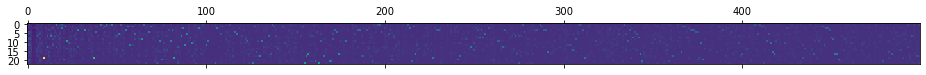

In [15]:

obs = df_dep_hashtags_count.to_numpy()
chi2, p, dof, ex = stats.chi2_contingency(obs)
cont_mat = pd.DataFrame(columns=hashtag_list, index=df_dep_hashtags.index, dtype=float)

for i, row in enumerate(obs):
    for j, n in enumerate(row):
        cont_mat.iloc[i, j] = (n - ex[i, j])/np.sqrt(ex[i, j]) # according to https://docs.cortext.net/contingency-matrix/
plt.matshow(cont_mat)

In [16]:
dep_hashtags = []
df_dep_ht = df_dep_hashtags.copy()
for i in df_dep_ht.index:
    ht = []
    for col in cont_mat.columns:
        chi2 = cont_mat.loc[i, col]
        if chi2 > 1:
            ht.append((col, round(chi2, 2)))
    dep_hashtags.append(ht)
df_dep_ht["dep_hashtags"] = dep_hashtags
df_dep_ht["dep_hashtags"] = [sorted(ht, key = lambda x: x[1], reverse=True) \
                             for ht in df_dep_ht.dep_hashtags]

In [17]:
df_dep_ht = pd.merge(df_dep_ht
                         , gdf_departements
                         , how='inner'
                         , right_on="nom"
                         , left_on="nom"
                         , validate = "many_to_one"
                        ).reset_index(drop=True)
df_dep_ht["code"].astype(str)
df_dep_ht.shape

(23, 7)

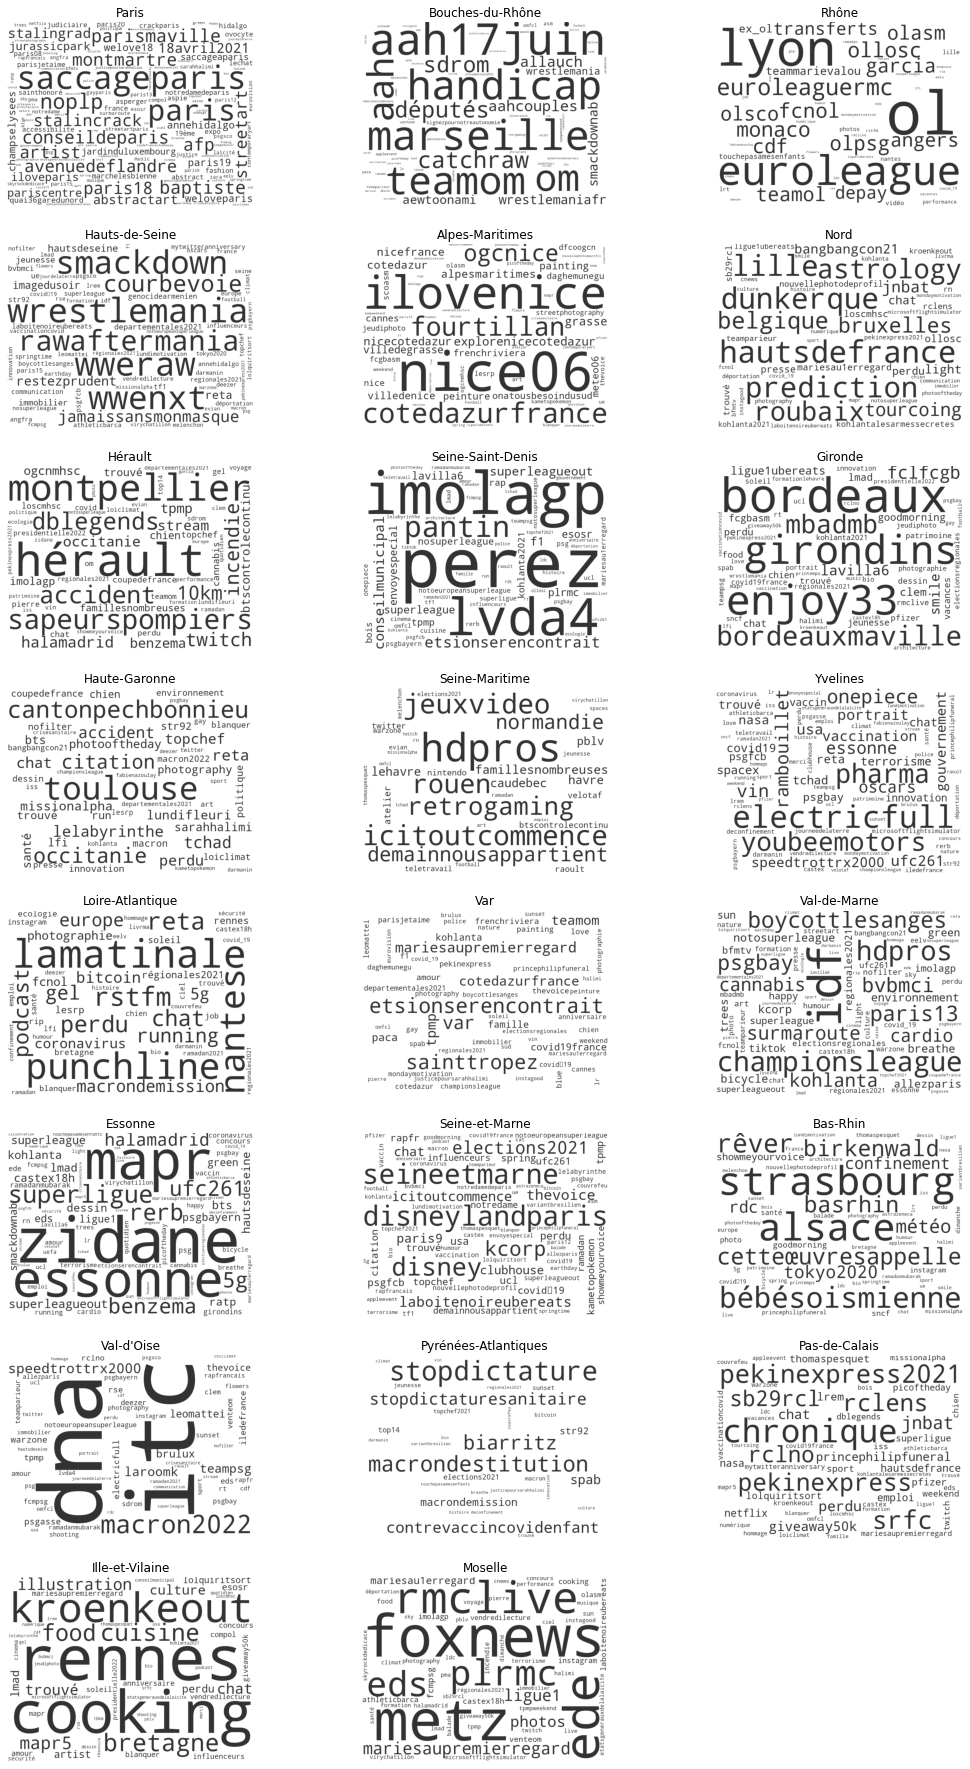

In [18]:
fig = plt.figure(figsize=(18,32))
cmap = cm.get_cmap('rainbow')

for l, dk in enumerate(df_dep_ht.dep_hashtags):
    loc = df_dep_ht.nom[l]
    data = {}
    
    for ht in dk:
        data[ht[0]] = ht[1]
                
    def color(word, **kwargs):
        c = (50, 50, 50)
        return c
        
    wc = WordCloud(width=800
                   , height=600
                   , max_words=200
                   , color_func=color
                   , background_color='white').generate_from_frequencies(data)
    ax = fig.add_subplot(8, 3, l+1)
    ax.set_title(f"{loc}")
    ax.imshow(wc)
    plt.axis('off')
plt.show()    

In [22]:
df_dep_ht['top_ht'] = [Counter(ht).most_common() for ht in df_dep_ht.all_hashtags]

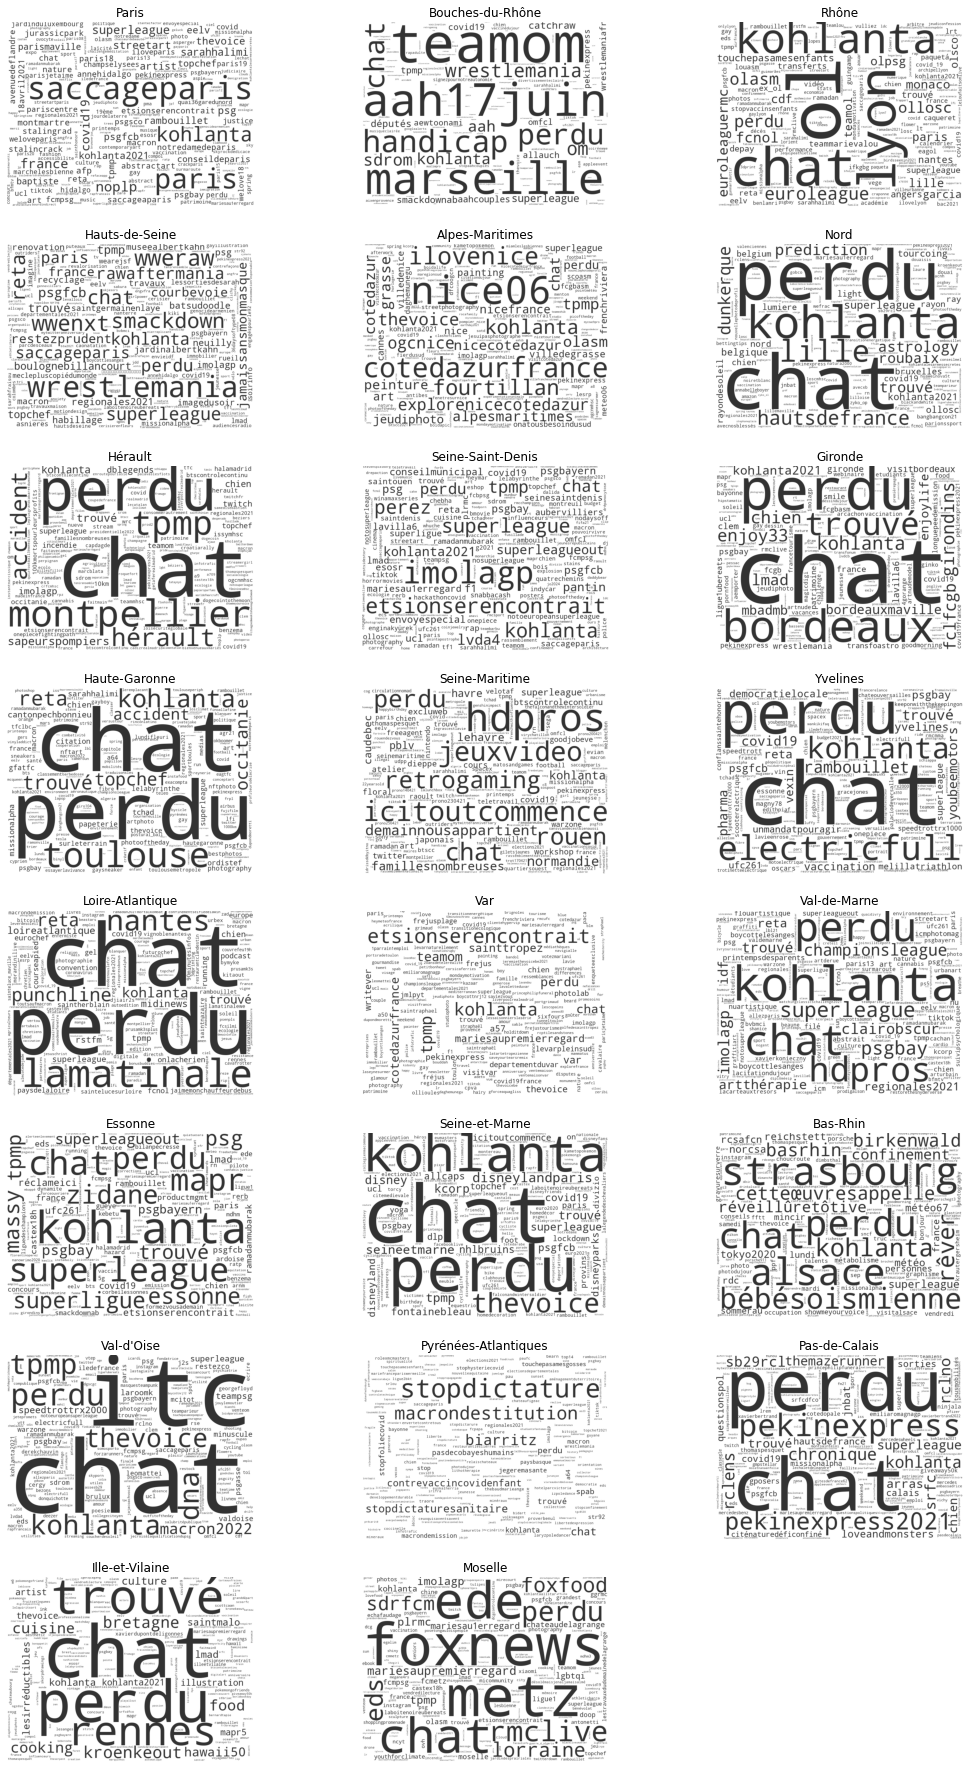

In [23]:
fig = plt.figure(figsize=(18,32))
cmap = cm.get_cmap('rainbow')

for l, dk in enumerate(df_dep_ht.top_ht):
    loc = df_dep_ht.nom[l]
    data = {}
    
    for ht in dk:
        data[ht[0]] = ht[1]
                
    def color(word, **kwargs):
        c = (50, 50, 50)
        return c
        
    wc = WordCloud(width=800
                   , height=600
                   , max_words=200
                   , color_func=color
                   , background_color='white').generate_from_frequencies(data)
    ax = fig.add_subplot(8, 3, l+1)
    ax.set_title(f"{loc}")
    ax.imshow(wc)
    plt.axis('off')
plt.show()    

In [30]:
from shapely.geometry import Point
import random
import itertools

scores = [[ht[1]for ht in hts] for hts in df_dep_ht.dep_hashtags]
scores = list(itertools.chain(*scores))


linear = cmp.LinearColormap(
    ['white', 'blue'],
    vmin=0, vmax=6000,
    caption='tweet_count' #Caption for Color scale or Legend
).to_step(12)

code = df_dep_ht["code"].to_list()


cmap = cm.get_cmap('Greys')


def style_function(feature):
    if feature["code"] in code:
        index = df_dep_ht[df_dep_ht["code"]==feature["code"]].index.values[0]
        tweet_num = df_dep_ht.at[index, "tweet_count"]
    else:
        tweet_num = None
    return {
        "fillOpacity": 0.5,
        "color": "black",
        "opacity": 0.25,
        "weight": 0.1,
        "fillColor": "#fff" if tweet_num is None else linear(tweet_num),
    }

m = folium.Map(
    location=[46.71109, 1.7191036],
    tiles="cartodbpositron",
    zoom_start=6,
)

for _, r in df_dep_ht.iterrows():
    #without simplifying the representation of each borough, the map might not be displayed
    #sim_geo = gpd.GeoSeries(r['geometry'])
    sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.001)
    geo_ = json.loads(sim_geo.to_json())
    geo_["features"][0]["code"] = r["code"]
    geo_j = folium.GeoJson(data=geo_,
                           style_function=style_function,)
    pt = sim_geo.centroid
    t = ''
    total_score = 0

    if len(df_dep_ht.at[_, "top_ht"]) > 0:
        data = {}
        for ht in df_dep_ht.at[_, "top_ht"]:
            data[ht[0]] = ht[1]
        
        max_f = dk[0][1]
            
        def color(word, **kwargs):
            f = data[word]/max_f
            c = cmap(f)[:3]
            c = tuple([int(k*255) for k in c])
            hexa = '#%02x%02x%02x' % c
            return hexa

        wc = WordCloud(width=160
                       , height=120
                       , max_words=200
                       , color_func=color
                       , background_color='white'
                       , scale= 1.0).generate_from_frequencies(data)
        svg = wc.to_svg()
        iframe = IFrame(svg, width=160+20, height=120+20)
        popup = folium.Popup(iframe, max_width=2650, sticky=True)
        popup.add_to(geo_j)
    geo_j.add_to(m)
linear.add_to(m)
        
m.save("hashtags_count.html")   
m

In [40]:
from shapely.geometry import Point
import random
import itertools

scores = [[ht[1]for ht in hts] for hts in df_dep_ht.dep_hashtags]
scores = list(itertools.chain(*scores))


linear = cmp.LinearColormap(
    ['white', 'blue'],
    vmin=0, vmax=6000,
    caption='tweet_count' #Caption for Color scale or Legend
).to_step(12)

code = df_dep_ht["code"].to_list()


cmap = cm.get_cmap('rainbow')


def style_function(feature):
    if feature["code"] in code:
        index = df_dep_ht[df_dep_ht["code"]==feature["code"]].index.values[0]
        tweet_num = df_dep_ht.at[index, "tweet_count"]
    else:
        tweet_num = None
    return {
        "fillOpacity": 0.5,
        "color": "black",
        "opacity": 0.25,
        "weight": 0.1,
        "fillColor": "#fff" if tweet_num is None else linear(tweet_num),
    }

m = folium.Map(
    location=[46.71109, 1.7191036],
    tiles="cartodbpositron",
    zoom_start=6,
)

for _, r in df_dep_ht.iterrows():
    #without simplifying the representation of each borough, the map might not be displayed
    #sim_geo = gpd.GeoSeries(r['geometry'])
    sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.001)
    geo_ = json.loads(sim_geo.to_json())
    geo_["features"][0]["code"] = r["code"]
    geo_j = folium.GeoJson(data=geo_,
                           style_function=style_function,)
    pt = sim_geo.centroid
    t = ''
    total_score = 0

    if len(df_dep_ht.at[_, "dep_hashtags"]) > 0:
        data = {}
        max_f = 0
        for ht in df_dep_ht.at[_, "dep_hashtags"]:
            text = ht[0]
            t += '#' + text + '\n'
            total_score += (ht[1]-min(scores))/(max(scores)-min(scores))*10
            data[ht[0]] = ht[1]
            if ht[1] > max_f: max_f = ht[1] 
            
        def color(word, **kwargs):
            f = data[word]/max_f
            c = cmap(f)[:3]
            c = tuple([int(k*160) for k in c])
            hexa = '#%02x%02x%02x' % c
            return hexa

        wc = WordCloud(width=160
                       , height=120
                       , max_words=200
                       , color_func=color
                       , background_color='white'
                       , scale= 1.0).generate_from_frequencies(data)
        svg = wc.to_svg()
        iframe = IFrame(svg, width=160+20, height=120+20)
        popup = folium.Popup(iframe, max_width=2650, sticky=True)
        popup.add_to(geo_j)
    geo_j.add_to(m)
linear.add_to(m)
        
m.save("hashtags_contingency_table.html")   
m